## Naive Bayes

### Introduction
We will start by working on Iris Dataset. 

In [2]:
from __future__ import print_function 
import os 

data_path = ['C:/Users/japor/Desktop/Machine Learning 501 Nervana/Intel-ML101-Class6/data']

### Question 1 
* Load Iris dataset
* Take a quick look at the data types
* Look at the skew values and decide if any transformations need to be applied. Use skew value 0.75 as a threshold. 
* Use `sns.pairplot` to plot the pairwise correlations and histograms. Use `hue = 'species'` as a keyword argument in order to see the distribution of species 


In [3]:
import pandas as pd 
import numpy as np 

filepath = os.sep.join(data_path + ['Iris_Data.csv'])
print (filepath)

data = pd.read_csv(filepath)
data.head()

C:/Users/japor/Desktop/Machine Learning 501 Nervana/Intel-ML101-Class6/data\Iris_Data.csv


sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [16]:
data.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [4]:
skew = pd.DataFrame(data.skew())
skew.columns = ['skew']
skew['too_skewed'] = skew['skew'] > 0.75
skew 

skew  too_skewed
sepal_length  0.314911       False
sepal_width   0.334053       False
petal_length -0.274464       False
petal_width  -0.104997       False

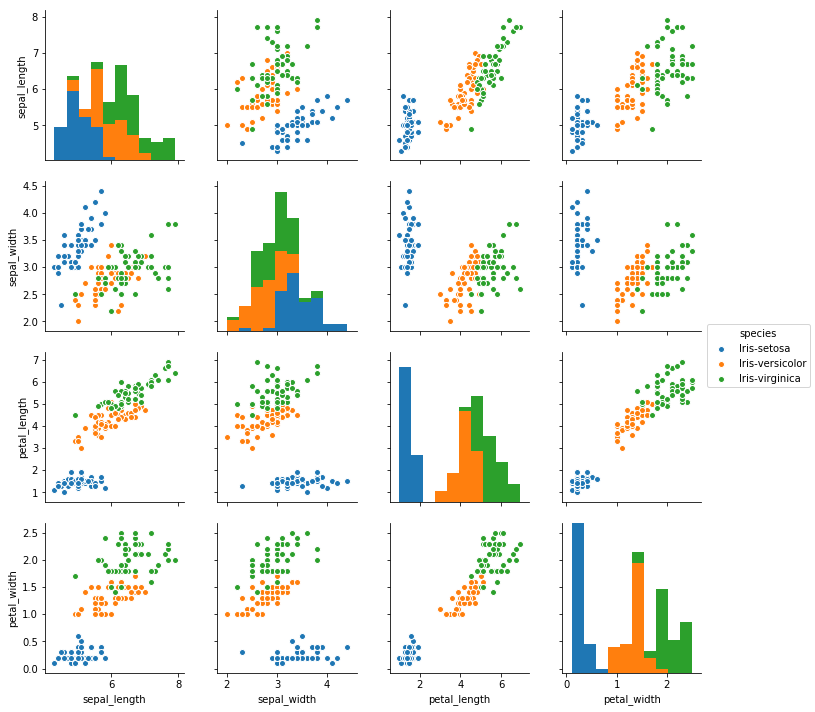

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
sns.pairplot(data, hue = 'species');


### Question 2 
Let's fit a Naive Bayes classifier to data in order to predict 'species' 
* Pick the appropriate type of Naive Bayes given the nature of your dataset (data type of columns). Recall, choices are: 
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
* Use `cross_val_score` to see how well your choice works. 

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
X = data[data.columns[:-1]]
y = data.species

GNB = GaussianNB()
cv_N = 4
scores = cross_val_score(GNB, X, y, n_jobs = cv_N, cv = cv_N)


In [12]:
X.shape

(150, 4)

In [10]:
y.head()

0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: species, dtype: object

In [14]:
print(scores)
np.mean(scores)

[ 0.94871795  0.94871795  0.91666667  1.        ]


0.95352564102564097

### Question 3
Now let's try all type of Naive Bayes and observe what happens 
* Compare the cross validation scores for Gaussian, Bernoulli and Multinomial Naive Bayes. 
* Why is BernoulliNB performing like it does? 


In [45]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
nb = {'gaussian': GaussianNB(), 
      'bernoulli': BernoulliNB(), 
      'multinomial': MultinomialNB()}
scores = {}
for key, model in nb.items(): 
    s = cross_val_score(model, X, y, cv = cv_N, n_jobs = cv_N, scoring = 'accuracy')
    scores[key] = np.mean(s)

scores 

{'bernoulli': 0.33333333333333331,
 'gaussian': 0.95352564102564097,
 'multinomial': 0.95299145299145294}

Using the Bernoulli distribution with this Naive Bayes Model is bad because the features are not binary and thus is not well modeled by a Bernoulli distribution.

### Question 4
What happens when we take away the predictive features?
* Check the pairplot histograms (diagonal) you produced above and identify the two most predictive features visually. 
* Remove the `petal_` features which are very predictive, and re-do the comparison above. That is, get the cross validation scores for all types of Naive Bayes. 

In [46]:
X = data[['sepal_length', 'sepal_width']]

scores_2 = {}
for key, model in nb.items(): 
    s = cross_val_score(model, X, y, cv = cv_N, n_jobs = cv_N, scoring = 'accuracy')
    scores_2[key] = np.mean(s)
    
scores_2

{'bernoulli': 0.33333333333333331,
 'gaussian': 0.7879273504273504,
 'multinomial': 0.68002136752136755}

Gaussian Naive Bayes and Multinomial Naive Bayes continue to be the best, but the prediction accuracy decreases significantly without the predictive features 

### Question 5 
This question explores how Naive Bayes algorithms can be affected when we push the underlying (naive) assumption too much. Recall that the naive assumption is that the features in the training set are *independent* from each other. 
* Create **0,1,3,5,10,50,100** copies of `sepal_length` and fit a `GaussianNB` for each one. 
* Keep track of and save the average `cross_val_score`.
* Create a plot of the saved scores over the number of copies. 

In [55]:
X = data[data.columns[:-1]]

n_copies = [0,1,3,5,10,50,100]

# Creates extra copies of 'sepal_length' column data
def create_copies_sepal_length(X,n): 
    X_new = X.copy()
    for i in range(n): 
        X_new['sepal_length_copy%s' %i] = X['sepal_length']
    return X_new 

# Measures average cross validation score for data with n copies of 'sepal_length'
def get_cross_val_score(n): 
    X_new = create_copies_sepal_length(X, n)
    scores = cross_val_score(GaussianNB(), X_new, y, cv = cv_N, n_jobs = cv_N) 
    return np.mean(scores)


In [56]:
avg_scores = pd.Series([get_cross_val_score(n) for n in n_copies], 
                       index = n_copies)

avg_scores

0      0.953526
1      0.940171
3      0.918803
5      0.886752
10     0.860043
50     0.774573
100    0.768697
dtype: float64

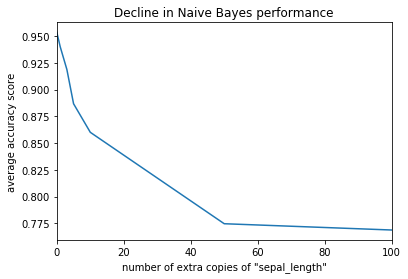

In [57]:
ax = avg_scores.plot()
ax.set(xlabel = 'number of extra copies of "sepal_length"', 
       ylabel = 'average accuracy score',
       title = 'Decline in Naive Bayes performance');

### Question 6 - Naive Bayes on Human Activity Recognition 
In this question, we'll explore discretizing the dataset and then fitting MultinomialNB
* Load the Human Activity Recognition Dataset 
* Look at the data types. It's all continuous except for the target. 
* Create `X` and `y` from data. y is the 'Activity' column 
* Create training and test splits. 
* Fit a GaussianNB to the training split. 
* Get predictions on the test set. 
* use sns.heatmap to plot the confusion matrix for predictions. 

In [58]:
data_path = ['C:/Users/japor/Desktop/Machine Learning 501 Nervana/Intel-ML101-Class6/data']
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [60]:
data.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X    ...     \
0         -0.923527         -0.934724    ...      
1         -0.957686         -0.943068    ...      
2         -0.977469         -0.938692    ...      
3         -0.989302         -0.938692    ...      
4         -0.990441         -0.942469    ...      

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   
1                        -0.595051                        -0.861499   
2                        -0.390748                        -0.760104   
3                        -0.117290                        -0.482845   
4                        -0.351471                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  Activity  
0             -0.841247              0.179941             -0.058627  STANDING  
1             -0.844788              0.180289             -0.054317  STANDING  
2             -0.848933              0.180637             -0.049118  STANDING  
3             -0.848649              0.181935             -0.047663  STANDING  
4             -0.847865              0.185151             -0.043892  STANDING  

[5 rows x 562 columns]

In [116]:
X = data[data.columns[:-1]]

# Encode activity label as integer 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
y = data.Activity

In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)


In [120]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (7209, 561)
X_test:  (3090, 561)
y_train:  (7209,)
y_test:  (3090,)


In [121]:
X_train.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
5538           0.267568          -0.015712          -0.065980   
2755           0.277109          -0.013876          -0.112776   
5813           0.223730          -0.048263          -0.105781   
7506           0.285830          -0.004668          -0.152746   
1334           0.270514          -0.019739          -0.129706   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
5538         -0.995271         -0.977984         -0.963060         -0.996078   
2755         -0.997565         -0.987851         -0.992859         -0.997805   
5813         -0.461582         -0.094674         -0.287821         -0.511609   
7506         -0.433399          0.009730          0.120867         -0.491119   
1334         -0.988424         -0.980260         -0.968742         -0.989403   

      tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  \
5538         -0.980578         -0.961130         -0.942153   
2755         -0.987097         -0.994136         -0.942406   
5813         -0.119351         -0.311649         -0.078237   
7506          0.047058          0.087327         -0.151067   
1334         -0.978525         -0.967611         -0.933788   

              ...           fBodyBodyGyroJerkMag-meanFreq()  \
5538          ...                                  0.420093   
2755          ...                                  0.545749   
5813          ...                                  0.221168   
7506          ...                                 -0.000990   
1334          ...                                  0.342991   

      fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
5538                        -0.616825                        -0.794250   
2755                        -0.785950                        -0.956767   
5813                        -0.175540                        -0.545833   
7506                        -0.107975                        -0.507438   
1334                        -0.547240                        -0.800976   

      angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
5538                    -0.004331                              0.212652   
2755                    -0.041486                              0.331615   
5813                     0.307722                              0.490644   
7506                    -0.310129                              0.097989   
1334                     0.001274                             -0.359362   

      angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
5538                         -0.370062                             -0.352681   
2755                          0.036768                              0.112289   
5813                         -0.842834                             -0.607873   
7506                          0.527328                             -0.689166   
1334                          0.041658                             -0.338905   

      angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
5538             -0.837084              0.099222             -0.101149  
2755             -0.872126              0.009535              0.043758  
5813             -0.854541              0.180849             -0.041994  
7506             -0.306913              0.303946              0.452417  
1334             -0.791197              0.139212              0.162886  

[5 rows x 561 columns]

In [122]:
y_train.head()

5538    1
2755    1
5813    3
7506    5
1334    2
Name: Activity, dtype: int64

In [123]:
clf = GaussianNB()
score = cross_val_score(clf, 
                        X_train, y_train, 
                        cv = cv_N, 
                        n_jobs = cv_N, 
                        scoring = 'accuracy')

score

array([ 0.68348115,  0.66463415,  0.66648169,  0.59143969])

In [124]:
mean_score = np.mean(score)
mean_score

0.65150916876629839

In [125]:
clf_gaussianNB = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

In [126]:
y_test_pred

array([3, 1, 1, ..., 1, 1, 5], dtype=int64)

In [127]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

ac = accuracy_score(y_test, y_test_pred)
ac

0.66957928802588995

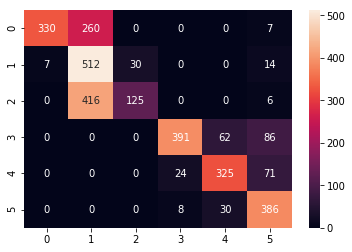

In [128]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot = True, fmt = 'd');

### Question 7 
Now, let's discretize the dataset from Question 6. There are many ways to do this, but we'll use `pd.DataFrame.rank(pct = True)`.

a) Create `X_discrete` from `X` using `.rank(pct = True)`

b) Look at the values. They are still not discrete. Modify `X_discrete` so that it is indeed discrete. (Hint: try to get the first 2 digits using `.applymap`)

c) Split `X_discrete` and y into training and test datasets 

d) Fit a MultinomialNB to the training split. 

e) Get predictions on the test set. 

f) Plot the confusion matrix for predictions 

In [173]:
X.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X          ...           \
0         -0.923527         -0.934724          ...            
1         -0.957686         -0.943068          ...            
2         -0.977469         -0.938692          ...            
3         -0.989302         -0.938692          ...            
4         -0.990441         -0.942469          ...            

   fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
0                        -0.074323                        -0.298676   
1                         0.158075                        -0.595051   
2                         0.414503                        -0.390748   
3                         0.404573                        -0.117290   
4                         0.087753                        -0.351471   

   fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                        -0.710304                    -0.112754   
1                        -0.861499                     0.053477   
2                        -0.760104                    -0.118559   
3                        -0.482845                    -0.036788   
4                        -0.699205                     0.123320   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                              0.030400                         -0.464761   
1                             -0.007435                         -0.732626   
2                              0.177899                          0.100699   
3                             -0.012892                          0.640011   
4                              0.122542                          0.693578   

   angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                             -0.018446             -0.841247   
1                              0.703511             -0.844788   
2                              0.808529             -0.848933   
3                             -0.485366             -0.848649   
4                             -0.615971             -0.847865   

   angle(Y,gravityMean)  angle(Z,gravityMean)  
0              0.179941             -0.058627  
1              0.180289             -0.054317  
2              0.180637             -0.049118  
3              0.181935             -0.047663  
4              0.185151             -0.043892  

[5 rows x 561 columns]

In [174]:
X.describe()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       10299.000000       10299.000000       10299.000000   
mean            0.274347          -0.017743          -0.108925   
std             0.067628           0.037128           0.053033   
min            -1.000000          -1.000000          -1.000000   
25%             0.262625          -0.024902          -0.121019   
50%             0.277174          -0.017162          -0.108596   
75%             0.288354          -0.010625          -0.097589   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      10299.000000      10299.000000      10299.000000      10299.000000   
mean          -0.607784         -0.510191         -0.613064         -0.633593   
std            0.438694          0.500240          0.403657          0.413333   
min           -1.000000         -1.000000         -1.000000         -1.000000   
25%           -0.992360         -0.976990         -0.979137         -0.993293   
50%           -0.943030         -0.835032         -0.850773         -0.948244   
75%           -0.250293         -0.057336         -0.278737         -0.302033   
max            1.000000          1.000000          1.000000          1.000000   

       tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  \
count      10299.000000      10299.000000      10299.000000   
mean          -0.525697         -0.614989         -0.466732   
std            0.484201          0.399034          0.538707   
min           -1.000000         -1.000000         -1.000000   
25%           -0.977017         -0.979064         -0.935788   
50%           -0.843670         -0.845068         -0.874825   
75%           -0.087405         -0.288149         -0.014641   
max            1.000000          1.000000          1.000000   

               ...           fBodyBodyGyroJerkMag-meanFreq()  \
count          ...                              10299.000000   
mean           ...                                  0.126708   
std            ...                                  0.245443   
min            ...                                 -1.000000   
25%            ...                                 -0.019481   
50%            ...                                  0.136245   
75%            ...                                  0.288960   
max            ...                                  1.000000   

       fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
count                     10299.000000                     10299.000000   
mean                         -0.298592                        -0.617700   
std                           0.320199                         0.308796   
min                          -1.000000                        -1.000000   
25%                          -0.536174                        -0.841847   
50%                          -0.335160                        -0.703402   
75%                          -0.113167                        -0.487981   
max                           1.000000                         1.000000   

       angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
count                 10299.000000                          10299.000000   
mean                      0.007705                              0.002648   
std                       0.336591                              0.447364   
min                      -1.000000                             -1.000000   
25%                      -0.124694                             -0.287031   
50%                       0.008146                              0.007668   
75%                       0.149005                              0.291490   
max                       1.000000                              1.000000   

       angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
count                      10299.000000                          10299.000000   
mean          

In [175]:
X_discrete = X.rank(pct = True)

In [176]:
X_discrete.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.752209           0.339839           0.162152          0.151762   
1           0.565006           0.556559           0.226333          0.016992   
2           0.618118           0.366929           0.357316          0.146422   
3           0.598505           0.231479           0.228954          0.109816   
4           0.473250           0.545393           0.324012          0.020099   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0          0.194194          0.462181          0.185164          0.192640   
1          0.262258          0.370619          0.008447          0.266822   
2          0.314011          0.251966          0.112341          0.335275   
3          0.191669          0.086222          0.082629          0.197009   
4          0.218079          0.089426          0.020682          0.228566   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X          ...           \
0          0.450529          0.265948          ...            
1          0.379454          0.044956          ...            
2          0.264103          0.182299          ...            
3          0.112341          0.182299          ...            
4          0.092436          0.063064          ...            

   fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
0                         0.186717                         0.547238   
1                         0.540247                         0.181183   
2                         0.887659                         0.430916   
3                         0.878920                         0.747160   
4                         0.415283                         0.479755   

   fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                         0.490339                     0.259928   
1                         0.208078                     0.621614   
2                         0.406447                     0.254782   
3                         0.753860                     0.372560   
4                         0.507428                     0.727935   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                              0.525002                          0.261773   
1                              0.481115                          0.173124   
2                              0.674143                          0.547723   
3                              0.474027                          0.784154   
4                              0.624818                          0.802505   

   angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                              0.491407              0.194776   
1                              0.915234              0.184484   
2                              0.956112              0.169919   
3                              0.195359              0.170599   
4                              0.127391              0.172735   

   angle(Y,gravityMean)  angle(Z,gravityMean)  
0              0.495097              0.348092  
1              0.496262              0.357608  
2              0.497330              0.371104  
3              0.499854              0.377221  
4              0.510050              0.389358  

[5 rows x 561 columns]

In [177]:
X_discrete_final = X_discrete.applymap(lambda x: int(x*100))

In [178]:
X_discrete_final.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0                 75                 33                 16                15   
1                 56                 55                 22                 1   
2                 61                 36                 35                14   
3                 59                 23                 22                10   
4                 47                 54                 32                 2   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0                19                46                18                19   
1                26                37                 0                26   
2                31                25                11                33   
3                19                 8                 8                19   
4                21                 8                 2                22   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X          ...           \
0                45                26          ...            
1                37                 4          ...            
2                26                18          ...            
3                11                18          ...            
4                 9                 6          ...            

   fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
0                               18                               54   
1                               54                               18   
2                               88                               43   
3                               87                               74   
4                               41                               47   

   fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                               49                           25   
1                               20                           62   
2                               40                           25   
3                               75                           37   
4                               50                           72   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                                    52                                26   
1                                    48                                17   
2                                    67                                54   
3                                    47                                78   
4                                    62                                80   

   angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                                    49                    19   
1                                    91                    18   
2                                    95                    16   
3                                    19                    17   
4                                    12                    17   

   angle(Y,gravityMean)  angle(Z,gravityMean)  
0                    49                    34  
1                    49                    35  
2                    49                    37  
3                    49                    37  
4                    51                    38  

[5 rows x 561 columns]

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_discrete_final, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [180]:
clf = MultinomialNB()
score = cross_val_score(clf, 
                        X_train, y_train, 
                        cv = cv_N, 
                        n_jobs = cv_N, 
                        scoring = 'accuracy')

score

array([ 0.79101996,  0.77771619,  0.76970033,  0.78432462])

In [181]:
mean_score = np.mean(score)
mean_score

0.78069027491544962

In [182]:
clf_multinomialNB = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

In [183]:
ac = accuracy_score(y_test, y_test_pred)
ac

0.79061488673139158

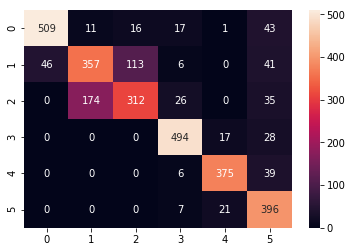

In [184]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot = True, fmt = 'd');